# Imports

In [22]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# import en_core_web_sm
nlp = spacy.load("en_core_web_sm")
# stopwords = nlp.Defaults.stop_words
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.decomposition import NMF
from sklearn import preprocessing
from nltk import ngrams
from nltk import FreqDist
from sklearn.decomposition import LatentDirichletAllocation as LDA
# nltk.download('all')

In [23]:
# charts
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [24]:
#warnings
import warnings
warnings.filterwarnings('ignore')

#options
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

# Functions

### 1. Data cleaning

In [25]:
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # clean_text = re.sub('\S*\d\S*\s*', '', clean_text)
    
    return clean_text

def remove_punctuation(text):
    punctuation = text.translate(str.maketrans('', '', string.punctuation))
    return punctuation

def convert_to_lowercase(text):
    text_lower = text.lower()
    return text_lower

def remove_stopwords(text):
    # stop_words = set(stopwords('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in STOP_WORDS]
    return ' '.join(filtered_words)


def replace(text):
    replaced = text.replace('xxxx', '').replace('-PRON-', '')

    return replaced



### 2. Merge cleaning functions for one function

In [26]:
def preprocessing_data(text):
    
    text = remove_special_characters(text) #pass
    text = remove_punctuation(text) #pass
    text = convert_to_lowercase(text) #pass
    text = remove_stopwords(text) #pass
    text = replace(text) #pass
    return text

### 3. Restore basic forms of words

In [27]:
def lemmatization(text):
    doc = nlp(text)
    lem_tokens = [token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS]
    return ' '.join(lem_tokens)

def stemming(text):
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    stem_words = [stemmer.stem(word) for word in words if word.text.lower() not in STOP_WORDS]
    return ' '.join(stem_words)

def remove_POS_tags(text):
    doc = nlp(text)
    result = [token.text for token in doc if token.tag_ == 'NN']  # check for nouns
    return ' '.join(result)

# finding ngrams

In [28]:
def get_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return list(n_grams)

def get_top_ngrams(data, n, top=30):
    combined_text = ' '.join(data.astype(str))
    n_grams = get_ngrams(combined_text, n)
    freq_dist = FreqDist(n_grams)
    return freq_dist.most_common(top)

# Importing data 

### dataset - https://www.kaggle.com/datasets/abhishek14398/automatic-ticket-classification-dataset/data

In [29]:
path = "complaints.json"
open_path = open(path) 
read_data = json.load(open_path)
df=pd.json_normalize(read_data)

In [30]:
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product']]
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})

# data modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)
df[df['complaint_text']==''] = np.nan
df = df[~df['complaint_text'].isnull()]

# text cleaning

In [62]:

data = df # replace to have possibility to load back original data
data['clean'] = data['complaint_text'].apply(lambda x: preprocessing_data(x)) # new column with preprocessed data
data['clean'] = data['clean'].apply(lambda x: lemmatization(x))
data['clean'] = data['clean'].apply(lambda x: remove_POS_tags(x))

### Check data

(array([9.016e+03, 6.377e+03, 2.803e+03, 1.296e+03, 7.990e+02, 3.090e+02,
        1.590e+02, 8.100e+01, 5.800e+01, 4.100e+01, 3.400e+01, 1.800e+01,
        1.500e+01, 1.100e+01, 1.200e+01, 5.000e+00, 6.000e+00, 4.000e+00,
        2.000e+00, 1.000e+00, 1.000e+01, 0.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([    0.  ,   248.32,   496.64,   744.96,   993.28,  1241.6 ,
         1489.92,  1738.24,  1986.56,  2234.88,  2483.2 ,  2731.52,
         2979.84,  3228.16,  3476.48,  3724.8 ,  3973.12,  4221.44,
         4469.76,  4718.08,  4966.4 ,  5214.72,  5463.04,  5711.36,
         5959.68,  6208.  ,  6456.32,  6704.64,  6952.96,  7201.28,
         7449.6 ,  7697.92,  7946.24

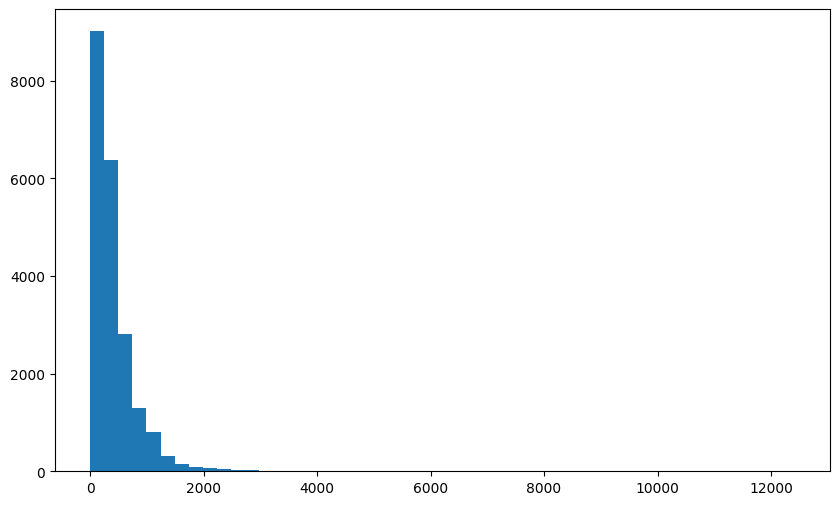

In [32]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
# doc_lens = [len(d) for d in data.clean]
doc_lens = [len(d) for d in data.clean]
plt.hist(doc_lens, bins = 50)

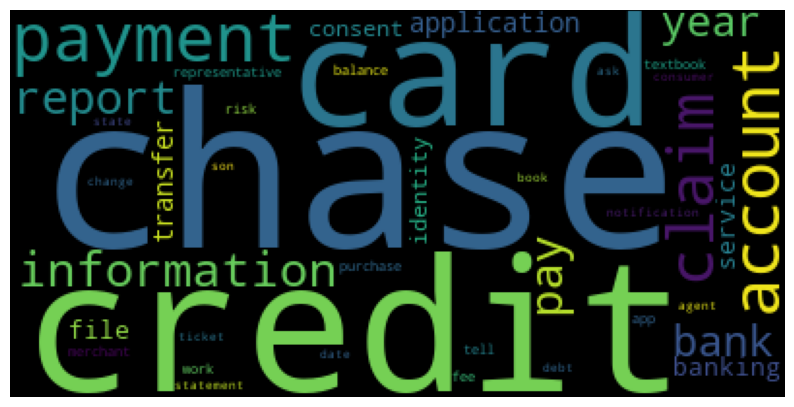

In [33]:

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['clean']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Topic Modelling
### in this dataset I have too much categories, so my plan is to change quantity of categories to 5.
### This can be done by NFM or LDA
###
###
###

### Finding top n-grams

In [34]:
top_unigrams = get_top_ngrams(data['clean'], 1)
top_bigrams = get_top_ngrams(data['clean'], 2)
top_trigrams = get_top_ngrams(data['clean'], 3)

print("\n top unigrams : \n", top_unigrams[:5])
print("\n top top_bigrams : \n",top_bigrams[:5])
print("\n top top_trigrams : \n",top_trigrams[:5])


 top unigrams : 
 [(('chase',), 59956), (('account',), 43623), (('credit',), 33844), (('card',), 30214), (('payment',), 21160)]

 top top_bigrams : 
 [(('credit', 'card'), 12840), (('credit', 'report'), 3962), (('chase', 'credit'), 3435), (('call', 'chase'), 3355), (('check', 'account'), 3031)]

 top top_trigrams : 
 [(('chase', 'credit', 'card'), 2469), (('credit', 'card', 'account'), 1067), (('credit', 'card', 'company'), 981), (('credit', 'card', 'chase'), 811), (('chase', 'customer', 'service'), 583)]


### Vectorizer

In [35]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
dtm = tfidf.fit_transform(data['clean']) # document term metrix
feature_names = np.array(tfidf.get_feature_names_out())

In [36]:
# model = CountVectorizer(min_df=2, max_df=0.95, stop_words='english')
# dtm = model.fit_transform(data['clean']) # document term metrix
# feature_names = np.array(model.get_feature_names_out())

### NFM

In [60]:
from sklearn.preprocessing import normalize

num_topics = 5  # You can adjust the number of topics as needed
nmf_model = NMF(n_components=num_topics, init='random', random_state=42)
nmf_matrix = nmf_model.fit_transform(dtm)

# Normalize the NMF matrix
nmf_matrix_normalized = normalize(nmf_matrix, axis=1)

# Assign topics to documents
data['topic'] = nmf_matrix_normalized.argmax(axis=1)


for topic in range(num_topics):
    topic_words_idx = nmf_model.components_[topic].argsort()[-15:][::-1]
    topic_words = [feature_names[i] for i in topic_words_idx]
    
    print(f"Top 15 words for Topic {topic}:\n")
    print(topic_words)
    print("\n")


Top 15 words for Topic 0:

['credit', 'card', 'report', 'inquiry', 'chase', 'account', 'score', 'company', 'information', 'debt', 'limit', 'application', 'reporting', 'letter', 'year']


Top 15 words for Topic 1:

['charge', 'card', 'chase', 'dispute', 'fee', 'transaction', 'purchase', 'merchant', 'fraud', 'claim', 'service', 'refund', 'email', 'time', 'statement']


Top 15 words for Topic 2:

['payment', 'balance', 'month', 'pay', 'fee', 'statement', 'day', 'time', 'chase', 'auto', 'date', 'credit', 'account', 'year', 'mortgage']


Top 15 words for Topic 3:

['account', 'check', 'bank', 'money', 'deposit', 'chase', 'fund', 'branch', 'day', 'transfer', 'number', 'business', 'transaction', 'customer', 'claim']


Top 15 words for Topic 4:

['loan', 'mortgage', 'chase', 'home', 'modification', 'property', 'year', 'letter', 'document', 'rate', 'foreclosure', 'time', 'request', 'sale', 'refinance']




In [59]:
# temp =data[['complaint_text','clean','category','topic']].groupby('topic').head(30)
# temp.sort_values('topic')

# data[data['Dominant_Topic'] == 4].head(30)


In [56]:


#Create the dictionary of Topic names and Topics
topic_mapping = {
    0: 'fees, Charges, and Account Balances',
    1: 'Credit Cards, Credit Reports',
    2: 'Other',
    3: 'Banking and Account activities',
    4: 'Payments, Loans, and Mortgages'
}

#Replace Topics with Topic Names
data['topic'] = data['topic'].map(topic_mapping)

data.to_csv('data.csv', index=False) # saving dataset

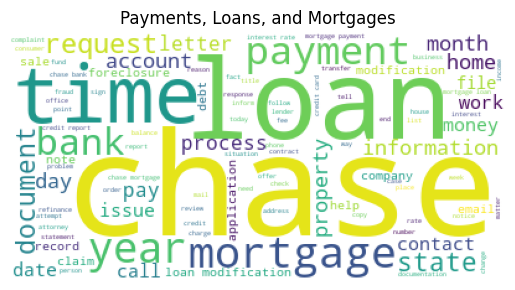

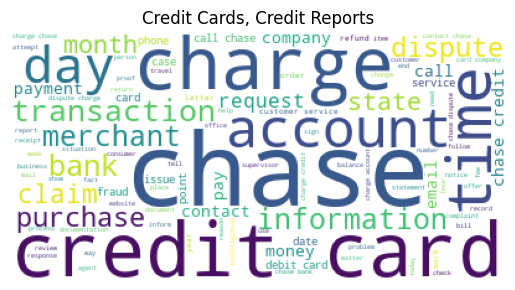

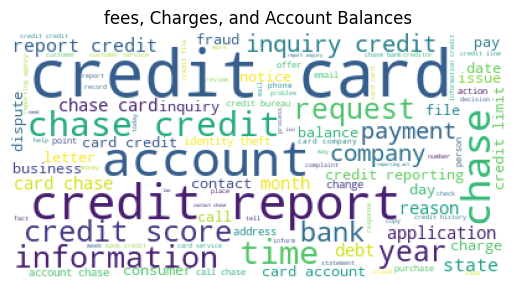

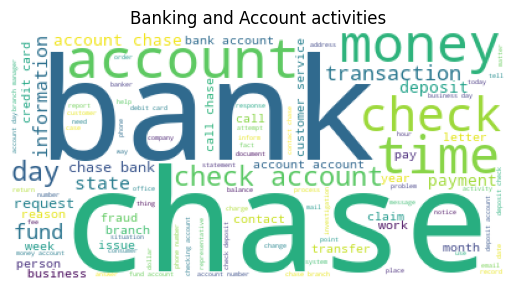

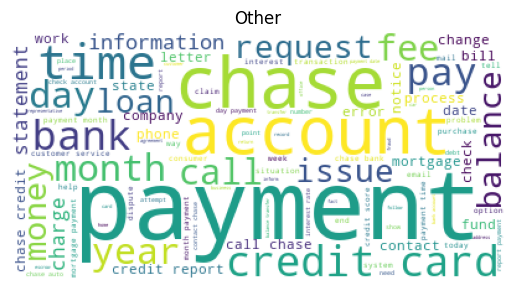

In [58]:
for x in data['topic'].unique():
	wc = WordCloud(background_color="white", max_words=100)
	wc.generate(data['clean'][(data['clean'].notnull()) & (data['topic'] == x)].to_string())
	plt.imshow(wc)
	plt.title(x)
	plt.axis("off")
	plt.show()

# importing dataset

In [65]:
data = pd.read_csv('data.csv')

# TESTING ON DIFFERENT CLASSIFICATORS

In [79]:
training_data = data[['clean','topic']]
# training_data = data[['clean','topic']]
# training_data.head()

In [84]:
# x - y  split
# X = training_data.complaint_text
X = training_data.clean
y = training_data.topic

In [83]:
training_data[training_data['clean']==''] = np.nan
training_data = training_data[~training_data['clean'].isnull()]

In [85]:
#Write your code to get the Vector count 

# Fit transform the X
count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

In [86]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code here to transform the word vector to tf-idf
#Fit transform word vector to TF-IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)

In [87]:


from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=40, stratify=y)



In [88]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [89]:
# utlity function to display the model report

def display_classification_report(model,metric):
    
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,average='weighted',multi_class='ovr'),2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba,average='weighted',multi_class='ovr'),2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.append(roc_auc_score_train)
    metric.append(roc_auc_score_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
  
    precision_train,recall_train,fscore_train,support_train=precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,fscore_test,support_test=precision_recall_fscore_support(y_test,y_test_pred,average='weighted')
    
    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)
    
    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(round(precision_train,2))
    metric.append(round(precision_test,2))
    metric.append(round(recall_train,2))
    metric.append(round(recall_test,2))
    metric.append(round(fscore_train,2))
    metric.append(round(fscore_test,2))
    
    print('Train Accuracy :',acc_score_train)
    print('Test Accuracy :',acc_score_test)
        
    model_report_train = classification_report(y_train,y_train_pred)
    model_report_test = classification_report(y_test,y_test_pred)
    
    print('Classification Report for Train:\n',model_report_train)
    print('Classification Report for Test:\n',model_report_test)


    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)

    plt.show()

In [90]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

In [91]:
def grid_search(model,folds,params,scoring):
    
    grid_search = GridSearchCV(model,
                                cv=folds, 
                                param_grid=params, 
                                scoring=scoring, 
                                n_jobs=-1, verbose=1)
    return grid_search

In [92]:
# utility function to display the best score and parameters of the GridSearchCV model
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

ROC AUC Score Train: 1.0
ROC AUC Score Test: 1.0
Train Accuracy : 0.98
Test Accuracy : 0.96
Classification Report for Train:
                                      precision    recall  f1-score   support

     Banking and Account activities       0.98      0.99      0.99      4258
       Credit Cards, Credit Reports       0.98      0.99      0.98      4078
                              Other       0.99      0.96      0.97      1806
     Payments, Loans, and Mortgages       0.98      0.98      0.98      3074
fees, Charges, and Account Balances       0.98      0.98      0.98      2582

                           accuracy                           0.98     15798
                          macro avg       0.98      0.98      0.98     15798
                       weighted avg       0.98      0.98      0.98     15798

Classification Report for Test:
                                      precision    recall  f1-score   support

     Banking and Account activities       0.96      0.98      0.97 

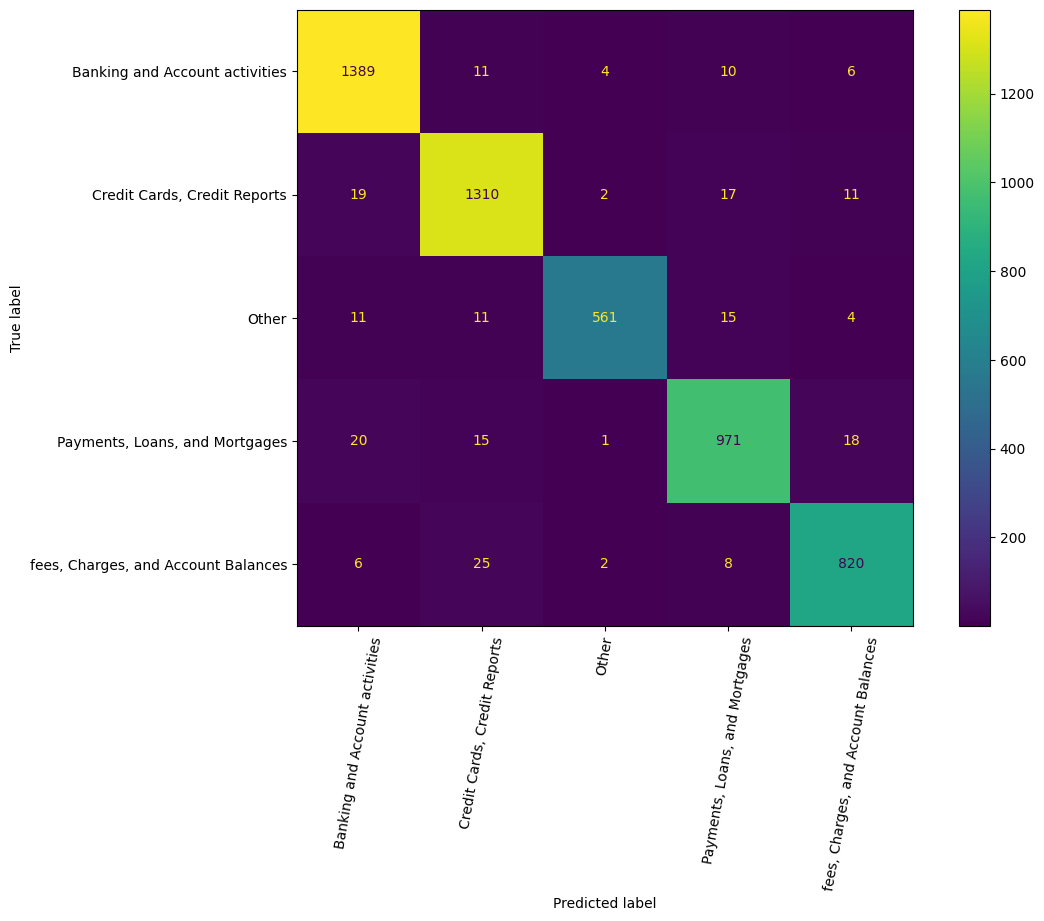

In [93]:
# Logistic Regression Classification
log_reg = LogisticRegression(random_state=40,solver='liblinear')
# fit model
log_reg.fit(X_train,y_train)
# display classification report
metric2=[]
display_classification_report(log_reg,metric2)